In [1]:
import re
import cv2
import numpy as np
import os
import tarfile
import urllib
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as img

from glob import glob
from matplotlib import pyplot as plt

## 1. image data load

In [2]:
image_path = glob("./ex_Data/ex8/*")
image_list = {}

for path in image_path:
    img = cv2.imread(path)
    
    image_name = path.split("/")[-1]
    image_name = re.sub(".jpg", "", image_name)
    
    image_list[image_name] = img
    
del image_list['background']
image_list.keys()

dict_keys(['hidden_image', 'my_image', 'cat_image'])

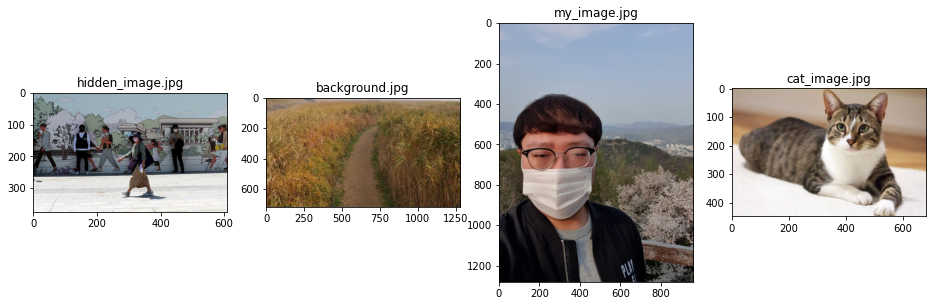

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/Exploration/ex_Data/ex8'
file_list = os.listdir(dir_path)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,8))

for i, ax in enumerate(axes.flatten()):
    image = cv2.imread(image_path[i])
    ax.set_title(file_list[i])
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.show()
fig.tight_layout()

***

<span>
[Dict] image_list - 원본 이미지 모음집 
</span>
    
***

## 2. DeepLab model design and weight download

In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [5]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

## 3. Search segmentation 

In [7]:
seg_image_list = image_list.copy()

for image in seg_image_list:
    print("이미지 이름 : {}".format(image))
    print("원본 이미지 차원 : {}".format(seg_image_list[image].shape))
    re_image, segmentation = seg_image_list[image] = MODEL.run(seg_image_list[image])

    print("수정 이미지 차원 : {}".format(re_image.shape))
    print("세그먼트 : {}\n".format(segmentation.max()))

이미지 이름 : hidden_image
원본 이미지 차원 : (376, 610, 3)
수정 이미지 차원 : (316, 513, 3)
세그먼트 : 15

이미지 이름 : my_image
원본 이미지 차원 : (1280, 960, 3)
수정 이미지 차원 : (513, 384, 3)
세그먼트 : 15

이미지 이름 : cat_image
원본 이미지 차원 : (448, 680, 3)
수정 이미지 차원 : (337, 513, 3)
세그먼트 : 8



***

<span>
[Dict] seg_image_list - 세그먼트 이미지 모음집 
</span>
    
***

## 4. Create mask and visualization

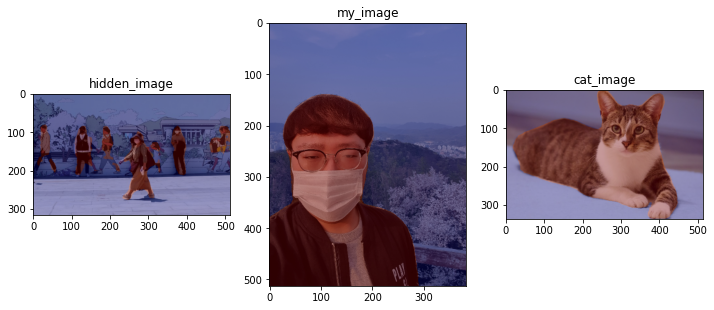

In [8]:
image_mask_list = {}
image_name = list(seg_image_list.keys())


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,8))

for i, ax in enumerate(axes.flatten()):
    image, segmentation = seg_image_list[image_name[i]]
    
    temp_image = image.copy()
    seg_map = np.where(segmentation == segmentation.max(), segmentation.max(), 0)
    
    img_mask = segmentation * (255/segmentation.max())
    img_mask = img_mask.astype(np.uint8)
    image_mask_list[image_name[i]] = img_mask
    
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(temp_image, 0.6, color_mask, 0.35, 0.0)  
    
    ax.set_title(image_name[i])
    ax.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

plt.show()
fig.tight_layout()

***

<span>
[Dict] image_mask_list - 마스크 이미지 모음집 
</span>
    
***

## 5. Restore segment

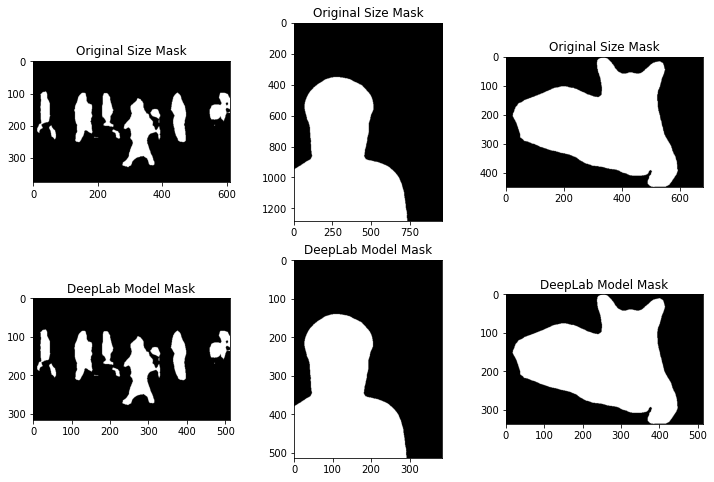

In [9]:
restore_segment_list = []

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
for i, ax in enumerate(axes.flatten()):
    if i < len(image_mask_list):
        img_mask_up = cv2.resize(image_mask_list[image_name[i]], image_list[image_name[i]].shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
        _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
                                                                            
        ax = plt.subplot(2,3,i+1)
        ax.set_title('Original Size Mask')
        ax.imshow(cv2.cvtColor(img_mask_up, cv2.COLOR_BGR2RGB))
        restore_segment_list.append(img_mask_up)       

        ax = plt.subplot(2,3,i+4)
        ax.set_title('DeepLab Model Mask')
        ax.imshow(cv2.cvtColor(image_mask_list[image_name[i]], cv2.COLOR_BGR2RGB))                                                                            

***

<span>
[List] restore_segment_list - 복원 이미지 모음집 
</span>
    
***

## 6. blur background and Out Focusing

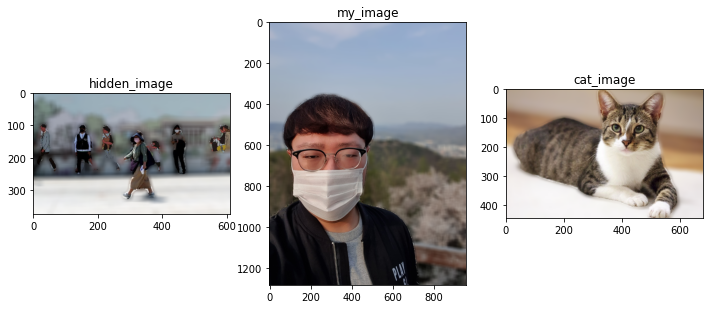

In [10]:
blur_background_image_list = []

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,8))
for i, ax in enumerate(axes.flatten()):
    # 블러 처리
    img_orig_blur = cv2.blur(image_list[image_name[i]], (20,20))
    
    # 추출
    img_mask_color = cv2.cvtColor(restore_segment_list[i], cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    blur_background_image_list.append(img_bg_blur)
    
    temp_image = np.where(img_mask_color==255, image_list[image_name[i]], blur_background_image_list[i])
    
    ax.set_title(image_name[i])
    ax.imshow(cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB))
    
plt.show()
fig.tight_layout()

***

<span>
[List] blur_background_image_list - 흐릿한 배경 추출 이미지 모음집 
</span>
    
***

## 7. 크로마키 이미지 추출

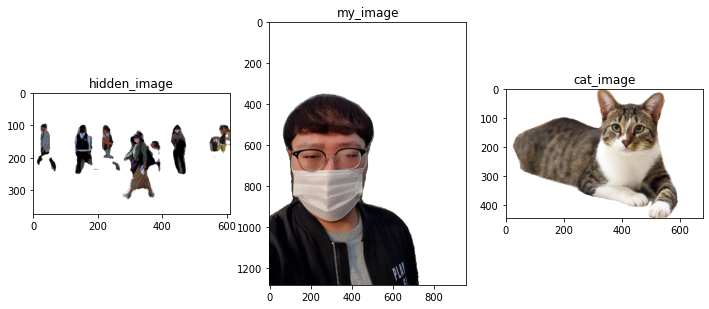

In [11]:
cromaki_gray_image_list = []
cromaki_color_image_list = []

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,8))
for i, ax in enumerate(axes.flatten()):    
    # cromaki background 전처리
    cromaki_image = np.full_like(image_list[image_name[i]], 0)
    cromaki_image[:,:,:] = 255
    cromaki_image = cv2.cvtColor(cromaki_image, cv2.COLOR_BGR2RGB)
       
    # cromaki 추출
    img_mask_color = cv2.cvtColor(restore_segment_list[i], cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    cromako_image_background = cv2.bitwise_and(cromaki_image, img_bg_mask)
    cromaki_gray_image_list.append(cromako_image_background)
    
    temp_image = np.where(img_mask_color==255, image_list[image_name[i]], cromako_image_background)
    cromaki_color_image_list.append(temp_image)
    
    ax.set_title(image_name[i])
    ax.imshow(cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB))
    
plt.show()
fig.tight_layout()

***

<span>
[List] cromaki_gray_image_list - 크로마키 범위 이미지 모음집<br>
[List] cromaki_color_image_list - 추출 크로마키 이미지 모음집
</span>
    
***

## 8. 커스텀 배경과 크로마키 합성

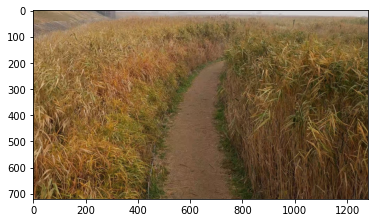

In [12]:
custom_background_image = cv2.imread(image_path[1])
plt.imshow(cv2.cvtColor(custom_background_image, cv2.COLOR_BGR2RGB))

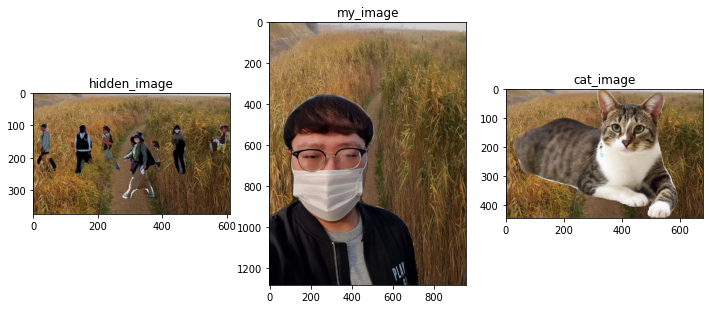

In [13]:
custom_image_list = []

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,8))
for i, ax in enumerate(axes.flatten()):
    bg_image = cv2.resize(custom_background_image, cromaki_color_image_list[i].shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    #temp_image = np.where(img_mask_color==255, cromaki_color_image_list[i], bg_image)
    
    blue_shape = np.where(cromaki_color_image_list[i][:,:,2] == 255, bg_image[:,:,2], cromaki_color_image_list[i][:,:,2])
    green_shape = np.where(cromaki_color_image_list[i][:,:,1] == 255, bg_image[:,:,1], cromaki_color_image_list[i][:,:,1])
    red_shape = np.where(cromaki_color_image_list[i][:,:,0] == 255, bg_image[:,:,0], cromaki_color_image_list[i][:,:,0])
    temp_image = np.stack([red_shape, green_shape, blue_shape], axis = 2)
    custom_image_list.append(temp_image)
    
    ax.set_title(image_name[i])
    ax.imshow(cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB))
    
plt.show()
fig.tight_layout()

***

<span>
[List] custom_image_list - 커스컴 배경 합성 이미지 모음집
</span>
    
***

## 9. 인물 사진의 문제점

***

<span>
인물 사진 만드는 프로젝트를 진행하면서, 가끔 오락실에 있는 스티커 사진을 찍는 촬영장이 생각났다.<br>
보통 친구들과 함께 단체사진을 찍는 경우가 종종 있는데, 이 때, 배경을 바꾸거나 얼굴만 클로즈업 하는 기능들을 사용하는 경우가 있다.<br>
이 점을 상기하며, 단체로 촬영한 그룹 사진을 넣어 사람이 여러명일때도 잘 추출하는지 실험해보았다.<br>
실험 결과 단체 사진에서도 사람의 형체를 잘 추출하였다.<br>
다만, 그룹을 하나의 마스크로 묶어 처리하는 모습을 보여주었다.<br><br>
이에, 사람의 벽화가 그리진 골목에 사람이 옆으로 지나가는 사진에서 잘 추출할 수 있을지 실험해보았다.<br>
실험 결과 아래 그림과 같이 사람의 형체를 잘 추출하지 못하는 문제를 보여주었다.
</span>
    
***

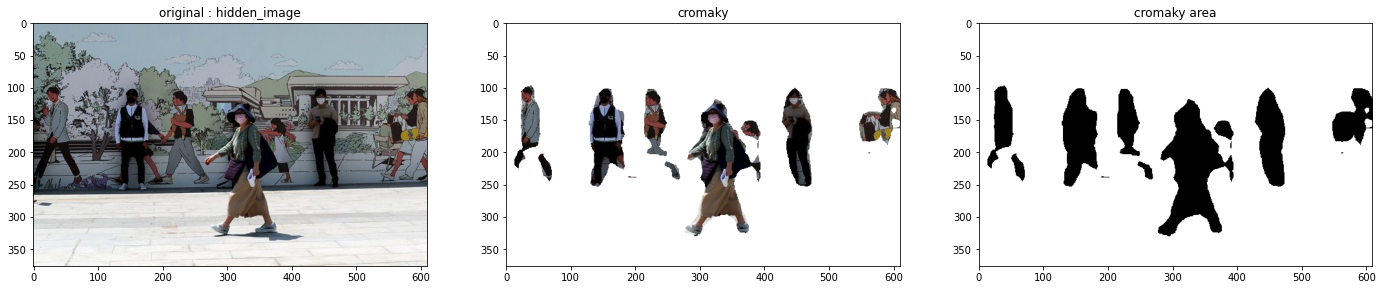

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,16))

for i, ax in enumerate(axes.flatten()):
    if i == 0:
        ax.set_title("original : {}".format(image_name[i]))
        ax.imshow(cv2.cvtColor(image_list[image_name[0]], cv2.COLOR_BGR2RGB))
    elif i == 1:
        ax.set_title("cromaky")
        ax.imshow(cv2.cvtColor(cromaki_color_image_list[0], cv2.COLOR_BGR2RGB))
    elif i == 2:
        ax.set_title("cromaky area")
        ax.imshow(cv2.cvtColor(cromaki_gray_image_list[0], cv2.COLOR_BGR2RGB))                     
    
plt.show()
fig.tight_layout()

***

<span>
위 결과와 같이, 벽화에 그려진 사람은 이미지가 잘려있는 경우가 대부분 이며, 실제 사람은 벽화 그림에 비해 잘 검출했으나, 경계면이 매끄럽지 않거나 일부 부위가 잘려있는 모습을 볼 수 있다.<br>
위와 같은 문제가 발행하는 이유는 초점을 맞춰야할 대상이 여러개 이고 분산화 되어있어, 초점의 기준이 명확하지 않기 때문이다.
</span>
    
***

## 10. 문제 해결 방법

***

<span>
초점의 대상이 여러개이고 분산되었을 때 사용할 수 있는 기법을 몇일간 탐색했으나 거의 대부분의 이미지 세그멘테이션 관련 모델들은 한 객체에 대한 Depth Map을 구하는것을 목적으로 만들어져 있어, 본 교육생의 목적과 맞는 모델을 찾지 못했다.<br><br>


때문에, 본 교육생은 초점의 대상이 여러개이고 분산된 상황에서 사용할 수 있는 이미지 세그멘테이션 기술의 가설을 제시한다.<br>
기존 image segmention model은 1개의 객체에 초점을 맞추고, 객체에 대한 Depth map을 기준으로 기능을 수행한다는 점을 착안하여<br>
하나의 이미지(화면)에서 세그먼트를 동시에 추출하는 것이 아닌, 각 세그먼트 마다 초점을 맞춘 뒤, 각각의 Mask를 추출하고, <br>
Mask로부터 크로마키를 추출한뒤 기존 배경과 합성한다. 이를 순서 목록으로 표현하면 아래 목록과 같다.<br><br>
    
1. 반복문으로 각 사람 객체에 초점을 맞춘다.<br>
2. 해당 객체에 초점을 맞추고 다른 객체는 배경화면와 같은 취급하여 포거싱 대상에서 제외한다.<br>
3. 해당 객체의 Mask를 추출한다.<br>
4. Mask를 저장하는 list 변수에 추가한다.<br>
5. 1~4번의 과정을 검출한 객체만큼 반복한다.<br>
6. 반복문을 통해 각 Mask를 활용해 크로마키를 추출하고와 기존 배경을 합성한다. 이 때, 합성된 사진을 다음 배경으로 사용하여 이전 Mask가 적용되도록 한다.<br>
7. Mask 객체만큼 반복한다.<br>
    
P.S - 시간상의 문제로 위 가설의 개발을 완성하지 못한게 아쉽다.<br>
</span>
    
***

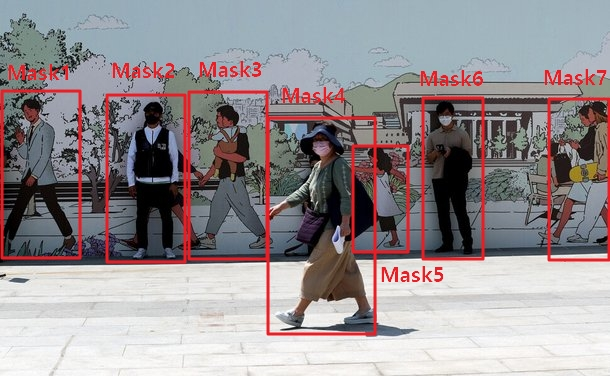